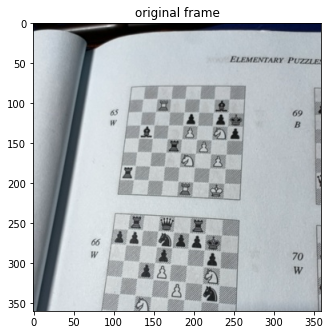

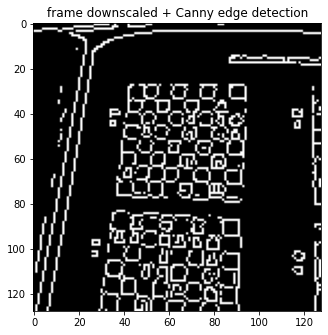

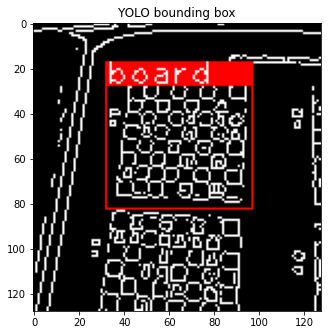

In [49]:
import numpy as np
import cv2
import time
import tensorflow as tf
import os
import matplotlib.pyplot as plt

from fen_chess_data.utils import distance, find_max_contour_area, find_outer_corners, do_perspective_transform, split_chessboard, preds_to_fen, generate_img

axes = [0,0,1,1,]

frame_orig = cv2.imread(f'fen_chess_data/data/test_img.jpg')

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(frame_orig)

plt.title('original frame')
plt.show()

d = 128
frame = cv2.resize(frame_orig, (d, d), interpolation = cv2.INTER_AREA)
height, width, channels = frame.shape

frame = cv2.Canny(frame, width, height)
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

pts = open('fen_chess_data/data/test_img_yolo_box.txt', 'r').read().split()

pts = [int(i) for i in pts]
x_orig, y_orig, w_orig, h_orig = tuple(pts)

pts = [int( float(i) * (frame.shape[0] / frame_orig.shape[0]) ) for i in pts]
x, y, w, h = tuple(pts)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(frame)

plt.title('frame downscaled + Canny edge detection')
plt.show()

cv2.rectangle(frame, (x, y), (x + w, y + h), 255, 1)
cv2.rectangle(frame, (x, y), (x + w, y + 10), 255, -1)
cv2.putText(frame, 'board', (x, y + 10), cv2.FONT_HERSHEY_PLAIN, 1, (255,255,255), 1)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(frame)

plt.title('YOLO bounding box')
plt.show()

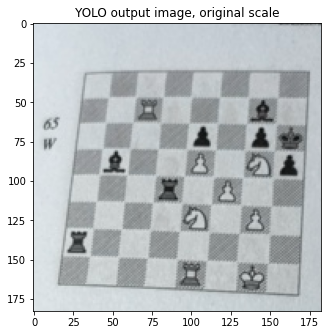

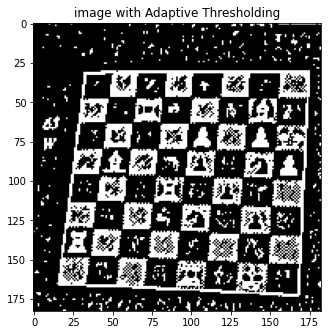

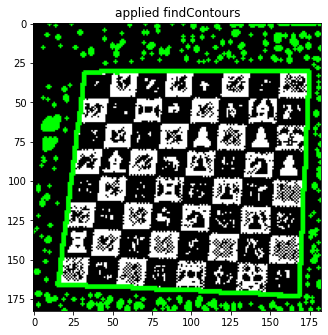

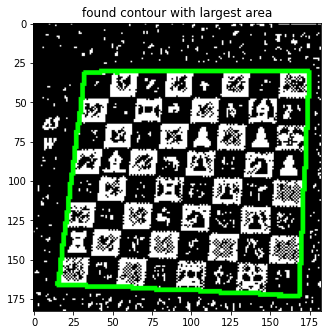

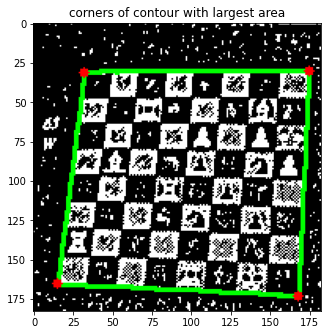

In [51]:

img = frame_orig[ y_orig : y_orig + h_orig, x_orig : x_orig + w_orig ].copy()

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(img)

plt.title('YOLO output image, original scale')
plt.show()

w = img.shape[0]

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 9, 3)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(img, cmap='gray')

plt.title('applied adaptiveThreshold')
plt.show()

contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

ctrs1 = img.copy()
ctrs1 = cv2.drawContours(ctrs1, contours, -1, (0, 255, 0), 2).copy()

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow( ctrs1 )

plt.title('applied findContours')
plt.show()

contours = find_max_contour_area(contours)
 
img = cv2.drawContours(img, contours, -1, (0, 255, 0), 2).copy()

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow( img )

plt.title('found contour with largest area')
plt.show()

c = contours[0]
peri = cv2.arcLength(c, True)
approx = cv2.approxPolyDP(c, 0.02 * peri, True)
pts = find_outer_corners(img, approx)

for p in pts:
    cv2.circle(img, (p[0], p[1]), 3, (255, 0, 0), -1)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(img)

plt.title('corners of contour with largest area')
plt.show()

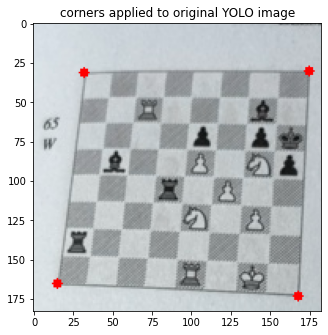

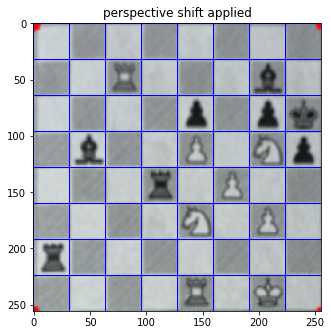

In [52]:
img_orig = frame_orig[ y_orig : y_orig + h_orig, x_orig : x_orig + w_orig ].copy()

for p in pts:
    cv2.circle(img_orig, (p[0], p[1]), 3, (255, 0, 0), -1)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(img_orig)

plt.title('corners applied to original YOLO image')
plt.show()

img_orig = do_perspective_transform(img_orig, pts)
img_orig = cv2.resize(img_orig, (256, 256), interpolation = cv2.INTER_AREA)

w, h, _ = img_orig.shape
dims = list(range(0, w + 1, w // 8))

for i in dims:
    img_orig = cv2.line(img_orig, (i, 0), (i, w), (0,0,255), 1)
    img_orig = cv2.line(img_orig, (0, i), (w, i), (0,0,255), 1)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(img_orig)

plt.title('perspective shift applied')
plt.show()

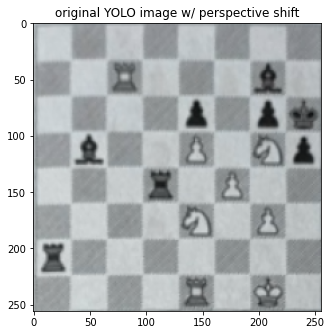

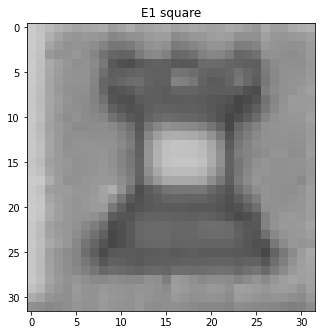

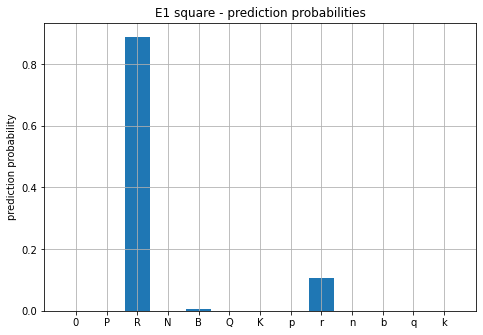

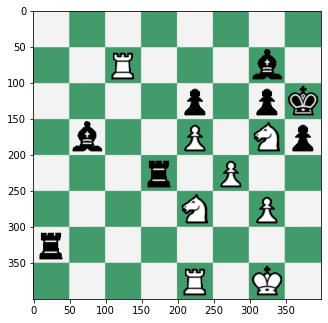

fen:  8/2R3b1/4p1pk/1b2P1Np/3r1P2/4N1P1/r7/4R1K1


In [54]:
img_orig = frame_orig[ y_orig : y_orig + h_orig, x_orig : x_orig + w_orig ].copy()
img_orig = do_perspective_transform(img_orig, pts)
img_orig_predict = img_orig.copy()

model = tf.keras.models.load_model('fen_chess_data/models/model_best.h5')

# predict class of each 64 squares
img_orig = cv2.resize(img_orig_predict, (256, 256), interpolation = cv2.INTER_AREA)

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(img_orig)

plt.title('original YOLO image w/ perspective shift')
plt.show()

# convert to B&W but with shape (w, h , 3) for model compatibility
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
img_orig = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2BGR)

imgs = split_chessboard(img_orig)
preds = model.predict( np.float32(np.array(imgs)) )

i = 60

fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(imgs[i])

plt.title('E1 square')
plt.show()

fig = plt.figure()
ax = fig.add_axes(axes)

ax.bar(
    list('0PRNBQKprnbqk'),
    preds[i]
)

plt.grid()
plt.title('E1 square - prediction probabilities')
plt.ylabel('prediction probability')
plt.show()

fen = preds_to_fen(preds)

final_img = generate_img(fen, large_dim=400)

# visualize final board
fig = plt.figure()
ax = fig.add_axes(axes)

ax.imshow(final_img)

plt.show()

print('fen: ', fen)